In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
"""
DenseNet的特点是在每个DenseBlock中，
每一层的输出都会与之前所有层的输出进行拼接，形成一个密集连接的特征图。
这样可以增加特征的多样性和梯度的流动，提高模型的性能。
DenseNet还使用了bottleneck layer和transition layer来减少参数量和计算量，提高效率。
"""
class _DenseLayer(nn.Sequential):
    """Basic unit of DenseBlock (using bottleneck layer) """
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        # 添加一个归一化层，用于规范化输入特征图
        self.add_module("norm1", nn.BatchNorm2d(num_input_features))
        # 添加一个ReLU激活函数，用于增加非线性
        self.add_module("relu1", nn.ReLU(inplace=True))
        # 添加一个1x1卷积层，用于减少特征图的数量，相当于一个瓶颈
        self.add_module("conv1", nn.Conv2d(num_input_features, bn_size*growth_rate,
                                           kernel_size=1, stride=1, bias=False))
        # 添加另一个批归一化层，用于规范化卷积层的输出
        self.add_module("norm2", nn.BatchNorm2d(bn_size*growth_rate))
        # 添加另一个ReLU激活函数，用于增加非线性
        self.add_module("relu2", nn.ReLU(inplace=True))
        # 添加一个3x3卷积层，用于增加特征图的数量，相当于一个扩张
        self.add_module("conv2", nn.Conv2d(bn_size*growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False))
        # 添加一个dropout层，用于防止过拟合
        self.add_module("dropout", nn.Dropout(p=drop_rate))
 
    def forward(self, x):
        # 将输入特征图通过各个层，并得到新的特征图
        new_features = super(_DenseLayer, self).forward(x)
        # 将新的特征图和输入特征图拼接在一起，形成一个密集连接的特征图
        return torch.cat([x, new_features], dim=1)
    
class _DenseBlock(nn.ModuleList):
    """DenseBlock"""
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features+i*growth_rate, growth_rate, bn_size,
                                drop_rate)
            self.append(layer)

    def forward(self, x):
        for layer in self:
            x = layer(x)
        return x

            
class _Transition(nn.Sequential):
    """Transition layer between two adjacent DenseBlock"""
    def __init__(self, num_input_feature, num_output_features):
        super(_Transition, self).__init__()
        self.add_module("norm", nn.BatchNorm2d(num_input_feature))
        self.add_module("relu", nn.ReLU(inplace=True))
        # 使用自适应平均池化层来替代1x1卷积层
        self.add_module("conv", nn.Conv2d(num_input_feature, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        
class DenseNet(nn.Module):
    "DenseNet-BC model"
    def __init__(self, growth_rate=32, k = 3, in_features=32, out_features=64, bn_size=1, drop_rate=0):
 
        super(DenseNet, self).__init__()
        
        # 使用Sequential来存储DenseBlock和Transition
        self.features = nn.Sequential()
 
        num_features = in_features
        i = 0
        num_layers = k
        
        block = _DenseBlock(num_layers, num_features, bn_size, growth_rate, drop_rate)
        self.features.add_module("denseblock%d" % (i+1,), block)
        num_features += num_layers*growth_rate
 
        transition = _Transition(num_features, out_features)
        self.features.add_module("transition%d" % (i+1,), transition)
        num_features = int(out_features)
        
        # 使用一个Sequential层来替代最后的批归一化层和ReLU激活函数
        self.features.add_module("normrelu", nn.Sequential(
            nn.BatchNorm2d(num_features),
            nn.ReLU(inplace=True)
        ))
 
        # params initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # 使用kaiming_normal_来初始化卷积层的权重
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                # 使用constant_来初始化批归一化层的偏置和权重
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1)
            elif isinstance(m, nn.Linear):
                # 使用zeros_来初始化线性层的偏置
                nn.init.zeros_(m.bias)
 
    def forward(self, x):
        # 直接将输入特征图通过Sequential层
        x = self.features(x)    
        return x

In [9]:
class ConvGRU(nn.Module):
    def __init__(self, x_channels=64, channels=32):
        super(ConvGRU, self).__init__()
        self.channels = channels
        self.x_channels = x_channels

        #输入到更新门的卷积，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv_x_z = nn.Conv2d(in_channels=self.x_channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        #隐藏状态到更新门的卷积层，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv_h_z = nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        #输入到重置门的卷积层，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv_x_r = nn.Conv2d(in_channels=self.x_channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        
        #隐藏状态到重置门的卷积层，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv_h_r = nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        #输入到候选隐藏状态的卷积层，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv =  nn.Conv2d(in_channels=self.x_channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        
        #重置后的隐藏状态到候选隐藏状态的卷积层，使用3x3的卷积核，步长为1，填充为1，保持输入和输出的尺寸相同
        self.conv_u =  nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1)
        self.lReLU = nn.LeakyReLU(0.2) #定义激活函数 #0.2
 
    def forward(self, x, h_t_1):
        """GRU卷积流程
        args:
            x: input
            h_t_1: 上一层的隐含层输出值
        shape:
            x: [in_channels, channels, width, lenth]
        """  
        z_t = F.sigmoid(self.conv_x_z(x) + self.conv_h_z(h_t_1)) #计算更新门z_t，使用sigmoid函数作为激活函数
        r_t = F.sigmoid((self.conv_x_r(x) + self.conv_h_r(h_t_1))) #计算重置门r_t，使用sigmoid函数作为激活函数
        h_hat_t = self.lReLU(self.conv(x) + self.conv_u(torch.mul(r_t, h_t_1))) #计算候选隐藏状态h_hat_t，使用带泄露项的ReLU函数作为激活函数
        
        #计算当前时刻的隐藏状态h_t，使用更新门对上一时刻的隐藏状态和候选隐藏状态进行加权平均
        h_t = torch.mul((1 - z_t), h_t_1) + torch.mul(z_t, h_hat_t)
        return h_t


In [10]:
class FRDU(nn.Module):
    def __init__(self, in_channels, channels, factor=2):
        super(FRDU, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.factor = factor
        self.convNorm = nn.Sequential(
            nn.Conv2d(in_channels+32, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        
        self.denseConvNorm = nn.Sequential(
            DenseNet(k = 3, in_features=channels, out_features=channels, bn_size=2),
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )    
        
        # 定义密集连接层
        self.denseLayer = DenseNet(k = 3, in_features=channels, out_features=channels, bn_size=2)
        # 定义GRU
        self.ConvGRU = ConvGRU(x_channels=channels)
        
        
    def forward(self, o_t_1, h_t_1):
        """
        o_t_t: Ot-1输入
        h_t_1: GRU的输出h_t_1
        """
        h_t_ori = h_t_1 # 保存原始的h_t_1

        h_t_1 = nn.Upsample(scale_factor=1/self.factor ,mode='bilinear', align_corners=True)(h_t_1) # 对h_t_1进行下采样，使用双线性插值
        
        o_t_1 = self.convNorm(torch.cat([o_t_1, h_t_1], dim=1)) # 将o_t_1和h_t_1在通道维度上拼接，然后通过第一个卷积归一化层

        o_t = self.denseLayer(o_t_1) # 将o_t_1通过密集连接层得到o_t
        x_t = self.denseConvNorm(o_t)  # 将o_t_1通过密集连接层和第二个卷积归一化层得到x_t
        
        x_t = nn.Upsample(scale_factor=self.factor ,mode='bilinear', align_corners=True)(x_t) # 对x_t进行上采样，使用双线性插值
        h_t = self.ConvGRU(x_t, h_t_ori) # 将x_t和原始的h_t_1作为卷积GRU的输入，得到h_t
        
        return o_t, h_t

<font size=6>GRUU-Net结构图</font><br />
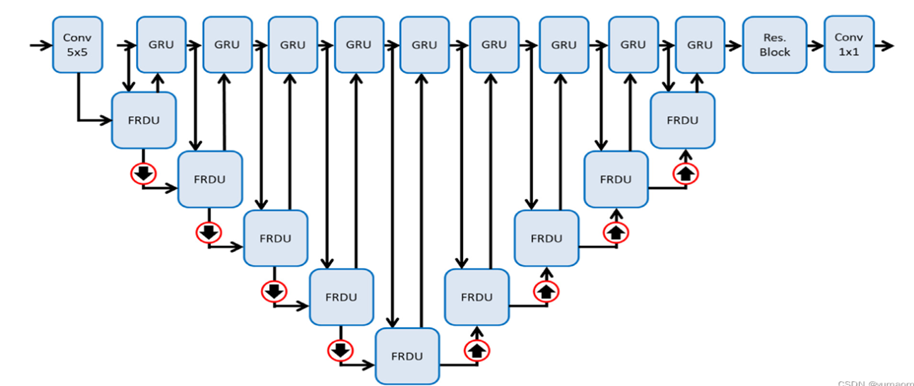

In [11]:
class GRUU_Net(nn.Module):
    def __init__(self, num_classes=2):
        super(GRUU_Net, self).__init__()
        self.input = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.FRDU_1 = FRDU(32, 64,factor=2)
        self.FRDU_2 = FRDU(64, 128,factor=4)
        self.FRDU_3 = FRDU(128, 256,factor=8)
        self.FRDU_4 = FRDU(256, 512,factor=16)
        self.FRDU_5 = FRDU(512, 512,factor=32)
        self.FRDU_6 = FRDU(512, 256,factor=16)
        self.FRDU_7 = FRDU(256, 128,factor=8)
        self.FRDU_8 = FRDU(128, 64,factor=4)
        self.FRDU_9 = FRDU(64, 32,factor=2)
        
        #定义残差块
        self.Resblock = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        
        # 定义分类分割层，输入通道数为32，输出通道数为num_classes（类别数）
        self.cls_seg = nn.Conv2d(32, num_classes, 3, padding=1)
        
    def forward(self, x):
        x = self.input(x)
        #FRDU1: 
        o_t, h_t = self.FRDU_1(o_t_1 = nn.MaxPool2d(2)(x), h_t_1 = x) #进行最大池化，取池化核中的最大值作为输入
        o_t, h_t = self.FRDU_2(o_t_1 = nn.MaxPool2d(2)(o_t), h_t_1 = h_t)
        o_t, h_t = self.FRDU_3(o_t_1 = nn.MaxPool2d(2)(o_t), h_t_1 = h_t)
        o_t, h_t = self.FRDU_4(o_t_1 = nn.MaxPool2d(2)(o_t), h_t_1 = h_t)
        o_t, h_t = self.FRDU_5(o_t_1 = nn.MaxPool2d(2)(o_t), h_t_1 = h_t)
 
        o_t, h_t = self.FRDU_6(o_t_1 = F.interpolate(o_t, scale_factor=2, mode="bilinear"), h_t_1 = h_t)#对上一层的输出进行上采样作为输入
        o_t, h_t = self.FRDU_7(o_t_1 = F.interpolate(o_t, scale_factor=2, mode="bilinear"), h_t_1 = h_t)
        o_t, h_t = self.FRDU_8(o_t_1 = F.interpolate(o_t, scale_factor=2, mode="bilinear"), h_t_1 = h_t)
        o_t, h_t = self.FRDU_9(o_t_1 = F.interpolate(o_t, scale_factor=2, mode="bilinear"), h_t_1 = h_t)
        
        h_t = self.Resblock(h_t) + h_t
        out = self.cls_seg(h_t)
        return out

In [12]:
from torch.utils.data import Dataset
import PIL.Image as Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import numpy as np


def train_dataset(img_root, label_root):
    imgs = []
    n = len(os.listdir(img_root))
    for i in range(n):
        img = os.path.join(img_root, "{}.png".format(i))

        label = os.path.join(label_root, "{}.png".format(i))
        imgs.append((img, label))
    return imgs


def test_dataset(img_root):
    imgs = []
    n = len(os.listdir(img_root))
    for i in range(n):
        img = os.path.join(img_root, "{}.png".format(i))
        imgs.append(img)
    return imgs


class TrainDataset(Dataset):
    def __init__(self, img_root, label_root, transform=None, target_transform=None):
        imgs = train_dataset(img_root, label_root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, item):
        x_path, y_path = self.imgs[item]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)


class TestDataset(Dataset):
    def __init__(self, img_root, transform=None):
        imgs = test_dataset(img_root)
        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, item):
        img_path = self.imgs[item]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.imgs)

<font size = 6>部分训练样本如下：</font><br/>
![Alt text](<V6{N0`9W1CD55@U)(KQY41Y.png>)

In [13]:
# 导入库
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


x_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

y_transform = transforms.ToTensor()

# 设置数据集路径
train_imageDir = "/Unet--master/dataset/train/image/"
train_labelDir = "/Unet--master/dataset/train/label/"
test_imageDir = "/Unet--master/dataset/test/"

train_dataset = TrainDataset(train_imageDir, train_labelDir, transform=x_transform, target_transform=y_transform)
test_dataset = TestDataset(test_imageDir, transform=x_transform)

batch_size = 1 #1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
print(len(train_dataset))
print(len(train_loader))

30
30


In [7]:
# 定义一个函数来计算评价指标
def metrics(out, labels):
    # 将输出张量和标签张量转换为二进制形式
    out = torch.sigmoid(out) # 使用sigmoid函数将输出值压缩到0-1之间
    out = (out > 0.5).float() # 使用阈值0.5将输出值转换为0或1
    labels = labels.float() # 将标签值转换为浮点数

    # 计算真正例、假正例、假负例和真负例的数量
    tp = (out * labels).sum() # 真正例是输出和标签都为1的像素的数量
    fp = (out * (1 - labels)).sum() # 假正例是输出为1但标签为0的像素的数量
    fn = ((1 - out) * labels).sum() # 假负例是输出为0但标签为1的像素的数量
    tn = ((1 - out) * (1 - labels)).sum() # 真负例是输出和标签都为0的像素的数量

    # 计算准确率、精确率、召回率和f1值
    accuracy = (tp + tn) / (tp + fp + fn + tn) # 准确率是正确预测的像素占总像素的比例
    precision = tp / (tp + fp) # 精确率是真正例占预测为正例的像素的比例
    recall = tp / (tp + fn) # 召回率是真正例占实际为正例的像素的比例
    f1 = 2 * precision * recall / (precision + recall) # f1值是精确率和召回率的调和平均数

    return accuracy, precision, recall, f1


<font size=6>BCEWithLogitsLoss损失计算函数</font> <br />
![Alt text](image.png)<br/>
它其实就是Sigmoid加BCE的计算函数的综合损失

In [10]:
#训练
def train(epochs, train_iter, lr):   
    loss_list = []
    acc_list = []

    model = GRUU_Net(num_classes=1).to(device)
    #载入预训练模型
    #model.load_state_dict(torch.load(r"E:/UnetTest3/checkpoints/GRUU-Net_85.pth"),strict=False)

    #选用adam优化器来训练 #Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #损失函数选用BCE损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        acc, p, r, f1_ = 0, 0, 0, 0

        for i, (features, labels) in enumerate(train_iter):
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            out = model(features)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            accuracy, precision, recall, f1 = metrics(out.cpu(), labels.cpu())
            acc += accuracy
            p += precision
            r += recall
            f1_ += f1
            
        train_loss = epoch_loss / (len(train_dataset)//batch_size)
        train_acc = acc / (len(train_dataset)//batch_size)
        train_pre = p / (len(train_dataset)//batch_size)
        train_recall = r / (len(train_dataset)//batch_size)
        train_f1 = f1_ / (len(train_dataset)//batch_size)
        #---------保存训练数据---------------
        loss_list.append(train_loss)
        acc_list.append(train_acc)
        
        # 打印训练信息
        print('epoch: {}\n训练损失: {:.4f}'.format(epoch+1, train_loss))
        # 打印评价指标
        print('准确率: {:.4f}, 精确率: {:.4f}, 召回率: {:.4f}, f1值: {:.4f}'.format(train_acc, train_pre, train_recall, train_f1))
        
        #----------------保存模型-------------------
        if np.mod(epoch+1, 5) == 0:
            torch.save(model.state_dict(), f'/UnetTest3/checkpoints/GRUU-Net_{epoch+1}.pth')
            print("模型保存成功！")
    return loss_list, acc_list

In [11]:
epochs_num = 100
lr = 0.001

train_loss, train_acc = train(epochs_num, train_loader, lr)

epoch: 1
训练损失: 0.3862
准确率: 0.8066, 精确率: 0.8535, 召回率: 0.9102, f1值: 0.8674
epoch: 2
训练损失: 0.2372
准确率: 0.8951, 精确率: 0.9269, 召回率: 0.9403, f1值: 0.9332
epoch: 3
训练损失: 0.2048
准确率: 0.9096, 精确率: 0.9434, 召回率: 0.9409, f1值: 0.9419
epoch: 4
训练损失: 0.1864
准确率: 0.9180, 精确率: 0.9451, 召回率: 0.9506, f1值: 0.9475
epoch: 5
训练损失: 0.1732
准确率: 0.9243, 精确率: 0.9538, 召回率: 0.9490, f1值: 0.9512
模型保存成功！
epoch: 6
训练损失: 0.1679
准确率: 0.9265, 精确率: 0.9531, 召回率: 0.9527, f1值: 0.9528
epoch: 7
训练损失: 0.1582
准确率: 0.9302, 精确率: 0.9558, 召回率: 0.9547, f1值: 0.9551
epoch: 8
训练损失: 0.1577
准确率: 0.9307, 精确率: 0.9566, 召回率: 0.9544, f1值: 0.9554
epoch: 9
训练损失: 0.1467
准确率: 0.9355, 精确率: 0.9586, 召回率: 0.9587, f1值: 0.9585
epoch: 10
训练损失: 0.1384
准确率: 0.9389, 精确率: 0.9610, 召回率: 0.9607, f1值: 0.9608
模型保存成功！
epoch: 11
训练损失: 0.1362
准确率: 0.9401, 精确率: 0.9629, 召回率: 0.9601, f1值: 0.9614
epoch: 12
训练损失: 0.1284
准确率: 0.9434, 精确率: 0.9656, 召回率: 0.9616, f1值: 0.9635
epoch: 13
训练损失: 0.1279
准确率: 0.9437, 精确率: 0.9649, 召回率: 0.9629, f1值: 0.9638
epoch: 14
训练损失: 0.1253
准确率: 0.9

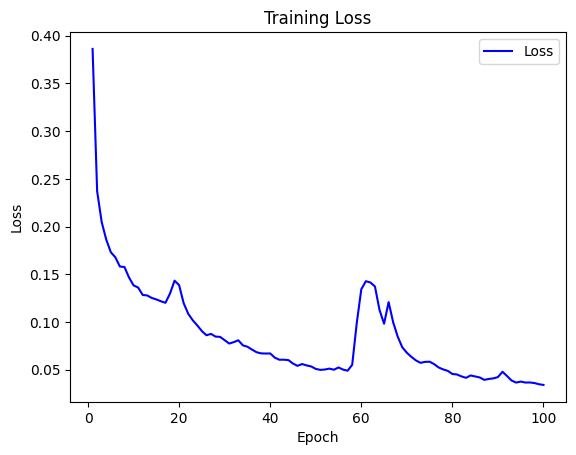

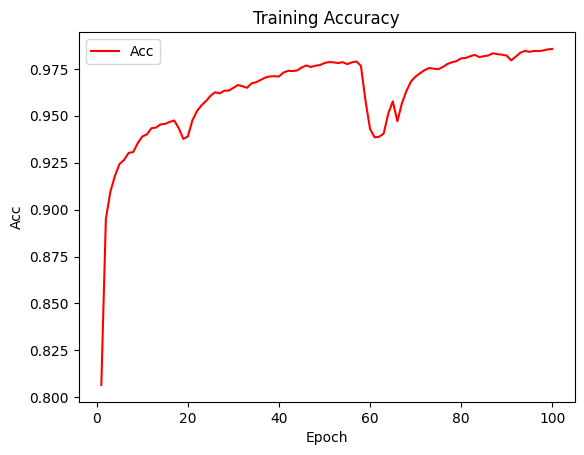

In [12]:
#画图
import matplotlib.pyplot as plt

def draw_loss_plot(epochs, train_loss):
    epochs = np.arange(epochs)
    plt.plot(epochs+1, train_loss, 'b-', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def draw_acc_plot(epochs, train_acc):
    epochs = np.arange(epochs)
    plt.plot(epochs+1, train_acc, 'r-', label='Acc')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    
draw_loss_plot(epochs_num, train_loss)
draw_acc_plot(epochs_num, train_acc)

In [18]:
def test(PATH):
    """
    模型测试
    :return:
    """
    model = GRUU_Net(num_classes=1).to(device)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    with torch.no_grad():
        for index, x in enumerate(test_loader):
            x = x.to(device)
            y = model(x)

            img_y = torch.squeeze(y).cpu().numpy()
            img_y = img_y[:, :, np.newaxis]
            img = img_y[:, :, 0]
            img = np.interp(img, (img.min(), img.max()), (0, 255))
            im = Image.fromarray(img)
            if im.mode == "F":
                im = im.convert('L')
            im.save("/UnetTest3/TestImage/" + str(index) + "_predict.png")
        print("图片分割成功！")

In [19]:
Model_PATH = "UnetTest3/checkpoints/GRUU-Net_100.pth"
test(Model_PATH)

图片分割成功！


In [20]:
import cv2
#防止产生色差
def DealMyImg(img):
    b, g, r = cv2.split(img)
    img_new = cv2.merge([r,g,b])
    return img_new

Text(0.5, 1.0, 'new')

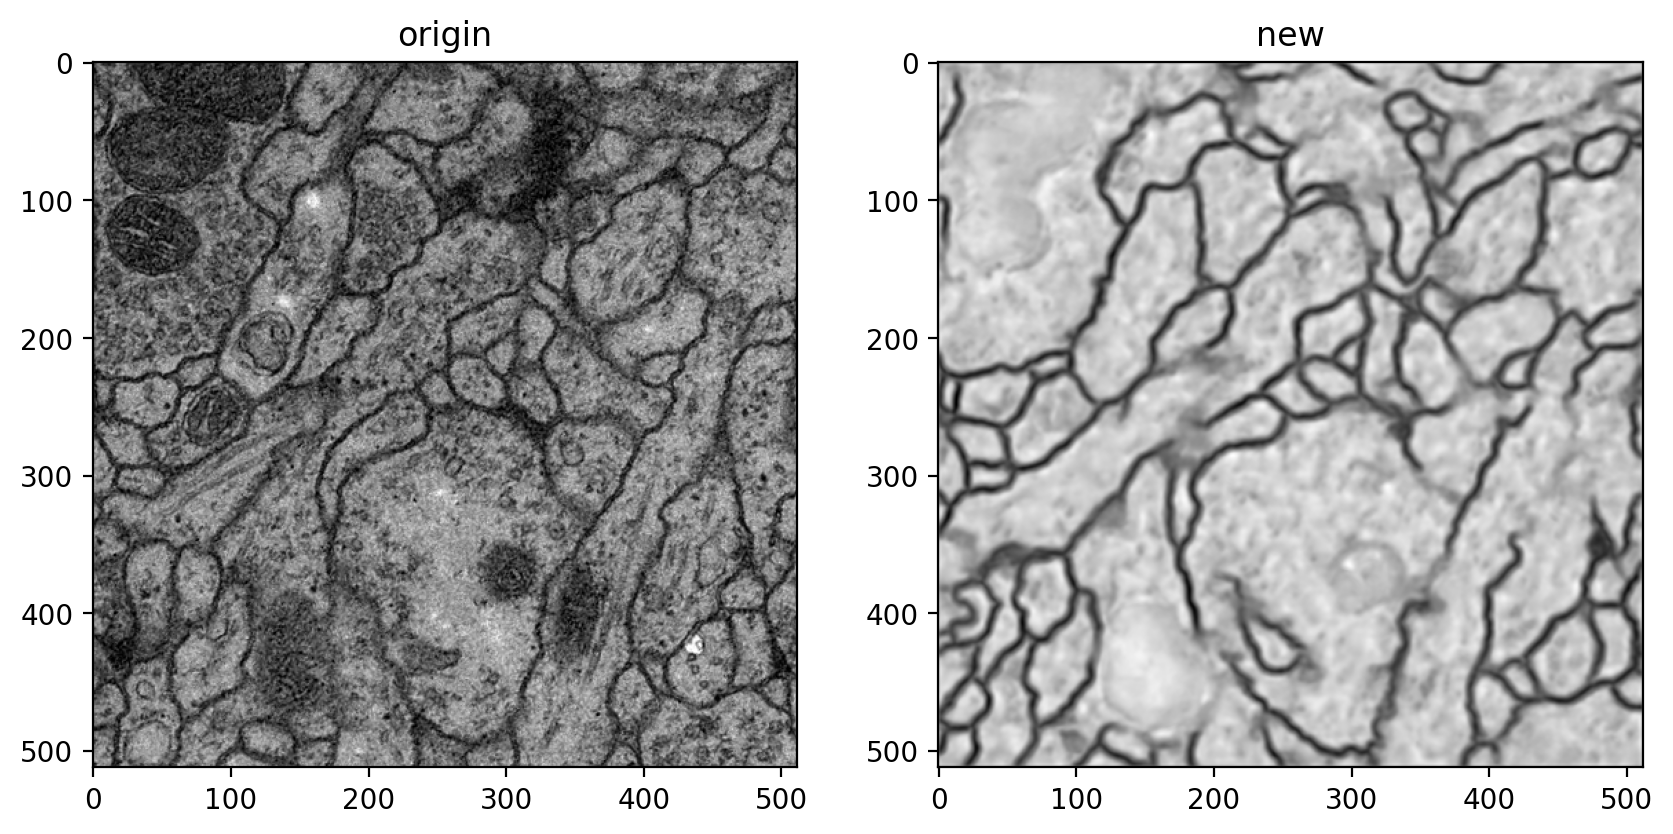

In [21]:
img_path = "/UnetTest3/test/24.png"
test_path = "/UnetTest3/TestImage/24_predict.png"
image_origin = cv2.imread(img_path, cv2.IMREAD_COLOR)
image_deal = cv2.imread(test_path, cv2.IMREAD_COLOR)

image_origin = DealMyImg(image_origin)
image_deal = DealMyImg(image_deal)

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,8),dpi=200)
axes[0].imshow(image_origin)
axes[0].set_title("origin")
axes[1].imshow(image_deal)
axes[1].set_title("new")

In [22]:
import cv2
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#防止产生色差
def DealMyImg(img):
    b, g, r = cv2.split(img)
    img_new = cv2.merge([r,g,b])
    return img_new
    
#模型应用
def applicate(model_path, img_path, target_path):
    """
    模型测试
    :return:
    """
    model = GRUU_Net(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        x_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
            ])
        img = Image.open(img_path)
        img = x_transform(img)
        
        x = img.to(device)
        x = x.reshape(1, 1, 512, -1)
        y = model(x)

        img_y = torch.squeeze(y).cpu().numpy()
        img_y = img_y[:, :, np.newaxis]
        img = img_y[:, :, 0]
        img = np.interp(img, (img.min(), img.max()), (0, 255))
        im = Image.fromarray(img)
        if im.mode == "F":
            im = im.convert('RGBA')
    
    image_origin = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_tgt = cv2.imread(target_path, cv2.IMREAD_COLOR)

    image_origin = DealMyImg(image_origin)
    image_tgt = DealMyImg(image_tgt)

    fig, axes=plt.subplots(nrows=1,ncols=3,figsize=(10,8),dpi=200)
    axes[0].imshow(image_origin)
    axes[0].set_title("origin")
    axes[1].imshow(im)
    axes[1].set_title("new")
    axes[2].imshow(image_tgt)
    axes[2].set_title("target")

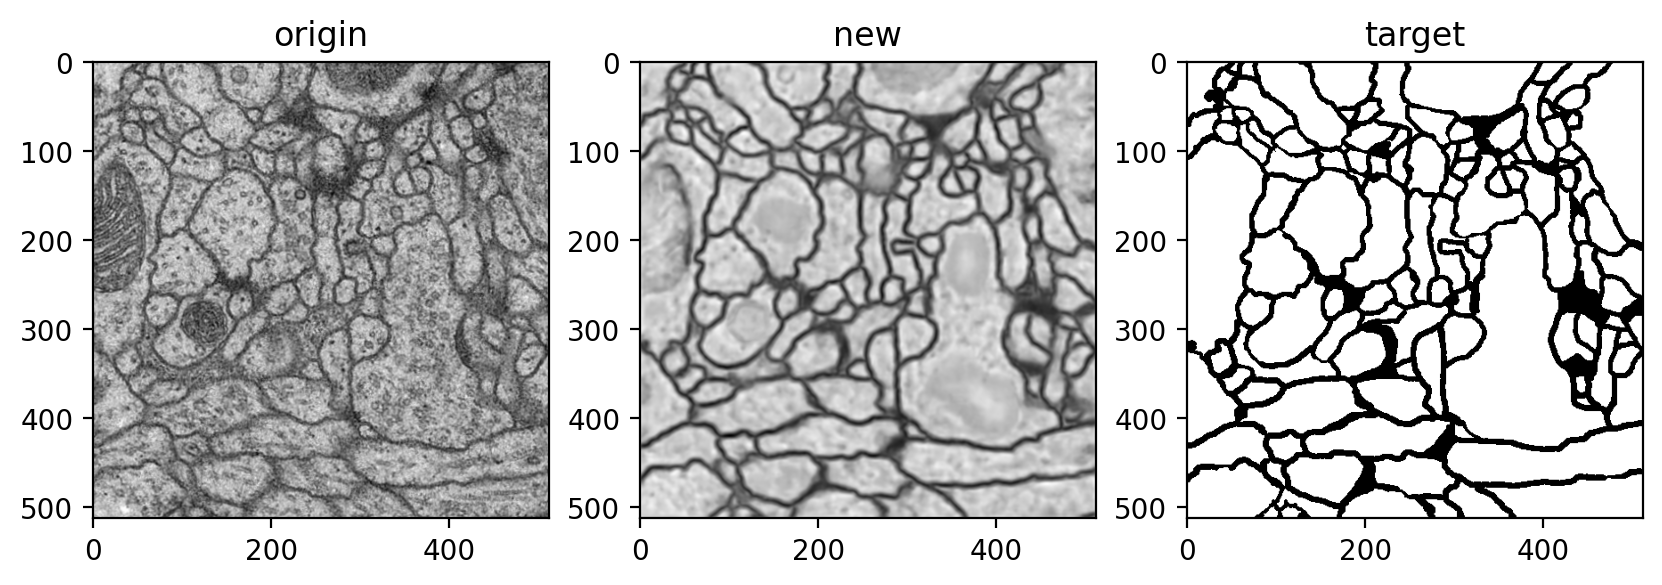

In [23]:
#输入图片
img_path = "/UnetTest3/train/image/10.png"
target_path = "/UnetTest3/train/label/10.png"
#导入模型
model_path = "/UnetTest3/checkpoints/GRUU-Net_100.pth"

applicate(model_path, img_path, target_path)